In [25]:
import numpy as np
import pandas as pd

In [26]:
df = pd.read_csv('./train.tsv', sep='\t')

In [27]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [28]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [29]:
len(df)

156060

In [30]:
df = df.dropna()

In [31]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

* Checking to see if any reviews are blank strings and not just NaN. 
* This means a review text could just be: "" or "  " or some other larger blank string.

In [32]:
s=" "
s.isspace()

True

In [33]:
df[df['Phrase'].str.isspace()]


,PhraseId,SentenceId,Phrase,Sentiment
2005,2006,76,,1


In [34]:
df = df[~df['Phrase'].str.isspace()]

In [35]:
df[df['Phrase'].apply(lambda review: review =='')]
# no empty strings
# can also use isin

,PhraseId,SentenceId,Phrase,Sentiment


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156059 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156059 non-null  int64 
 1   SentenceId  156059 non-null  int64 
 2   Phrase      156059 non-null  object
 3   Sentiment   156059 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.0+ MB


**Confirm the value counts per label:**

In [37]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27272
4     9206
0     7072
Name: Sentiment, dtype: int64

#### Training

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X = df['Phrase']
y=df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

### Training a Mode

**Creating a PipeLine that will both create a TF-IDF Vector out of the raw text data and fit a supervised learning model of our choice. Then fit that pipeline on the training data.**

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [41]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [42]:
def custom_tokenizer(text):
    # Tokenization
    tokens = text.split()
    
    # Remove stopwords, stem, and lemmatize the words
    processed_tokens = [
        stemmer.stem(token)
        for token in tokens
        if token.lower() not in stop_words
    ]
    
    # Return the processed tokens
    return processed_tokens

In [43]:

import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mrizv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
rfc=RandomForestClassifier()
pipe = Pipeline([('tfidf',TfidfVectorizer(tokenizer=custom_tokenizer)),('rfc',rfc)])


In [45]:
n_estimators=[64,100]
max_features=[1000,2000]
param_grid = {'rfc__n_estimators':n_estimators,'rfc__max_features':max_features}

In [46]:
grid_model = GridSearchCV(pipe,param_grid=param_grid,n_jobs=-1)

In [47]:
grid_model.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x0000029A308AAA60>)),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__max_features': [1000, 2000],
                         'rfc__n_estimators': [64, 100]})

In [56]:
grid_model.best_params_

{'rfc__max_features': 1000, 'rfc__n_estimators': 100}

In [49]:
# import joblib
# joblib.dump(pipe,'movie_review_model.pkl')

In [50]:
# new_model = joblib.load('movie_review_model.pkl')

**TASK: Create a classification report and plot a confusion matrix based on the results of your PipeLine.**

In [57]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [58]:
preds = grid_model.predict(X_test)
preds

array([2, 1, 1, ..., 2, 3, 1], dtype=int64)

In [60]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.45      0.31      0.37      1417
           1       0.52      0.45      0.48      5472
           2       0.71      0.80      0.75     15878
           3       0.53      0.49      0.51      6640
           4       0.47      0.33      0.39      1805

    accuracy                           0.62     31212
   macro avg       0.53      0.48      0.50     31212
weighted avg       0.61      0.62      0.61     31212



c:\Users\mrizv\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


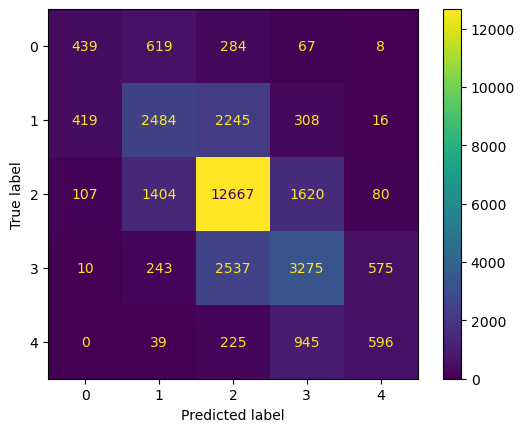

In [61]:
plot_confusion_matrix(grid_model,X_test,y_test)

In [66]:
# grid_model.predict(['Perfect movie ever, I love it and enjoyed a lot, I will recommend to everyone'])
# grid_model.predict(['Time well spent'])

array([3], dtype=int64)

## The End